In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rnd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from functools import reduce
from operator import add
from datetime import datetime
from pycm import ConfusionMatrix

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_transform as tft
import keras
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, 
                          AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, SeparableConv2D,
                          SeparableConv1D, AveragePooling1D, GlobalAveragePooling1D)
from tensorflow.keras import mixed_precision
import os
# import h5py
# import cv2

# import dill as pickle
import pickle5 as pickle
import collections

seizure_type_data = collections.namedtuple('seizure_type_data', ['patient_id','seizure_type', 'data'])

seed = 73


# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)

# 2. Set `python` built-in pseudo-random generator at a fixed value
rnd.seed(seed)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed)

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
path_drive = '/home/manu/Documents/1_UPM/TFM/code/'
path_dataset = '/home/manu/Documents/1_UPM/TFM/data/tuh/250hz/v1.5.2/images/fft_seizures_wl1_ws_0.75_sf_250_fft_min_1_fft_max_24_diff_seizures/'

In [43]:
f_cv = 'cv_split_3_fold_patient_wise_v1.5.2.pkl'

with open(path_drive+f_cv, 'rb') as f:
    cv = pickle.load(f)

In [44]:
existing_files = set(os.listdir(path_dataset))

In [45]:
test = list(set(cv['1']['val']).intersection(existing_files))
train_val = list(set(cv['1']['train']).intersection(existing_files))
train_val_labels = [path.split('_')[-1][:4] for path in train_val]

train, val = train_test_split(train_val, test_size=.05, random_state=seed, 
                              shuffle=True, stratify=train_val_labels)

In [46]:
with open(path_drive+'dict_seizures.pickle', 'rb') as f:
    d_seizures = pickle.load(f)

def get_generator(f, l_paths, first_frames=None):
    def func():
        if first_frames is None:
            return f(l_paths)
        else:
            return f(l_paths, first_frames)
    return func

def read_train_data(l_paths):
    for path in l_paths:
        with open(os.path.join(path_dataset, path), 'rb') as f:
            data = pickle.load(f)
        ind = rnd.randint(0, data.data.shape[0]-1)
        # x data
        x = data.data[ind,:,:].astype(np.float32)
        # y data
        arr = np.zeros(len(d_seizures.keys()))
        y = d_seizures[data.seizure_type]
        arr[y] = 1.
        yield x.T, arr
        

def read_test_data(l_paths):
    for path in l_paths:
        with open(os.path.join(path_dataset, path), 'rb') as f:
            data = pickle.load(f)
#         y data
        arr = np.zeros(len(d_seizures.keys()))
        y = d_seizures[data.seizure_type]
        arr[y] = 1.
        arr = np.tile(arr, (data.data.shape[0], 1))
        
        yield [d.T for d in data.data.astype(np.float32)], arr


def read_test_data_first_frames(l_paths, first_frames=-1):
    # message = f'Getting the first {first_frames} frames' if first_frames != -1 else 'Getting all frames'
    # print(message)
    for path in l_paths:
        with open(os.path.join(path_dataset, path), 'rb') as f:
            data = pickle.load(f)
        x = data.data
        y = data.seizure_type
        if first_frames != -1:
            x = x[:first_frames, :]
        
        arr = np.zeros(len(d_seizures.keys()))
        y = d_seizures[y]
        arr[y] = 1.
        arr = np.tile(arr, (x.shape[0], 1))
        
        yield [d.T for d in x.astype(np.float32)], arr

In [47]:
it = iter(read_train_data(train))
e = next(it)
input_shape = (e[0].shape, e[1].shape)
input_shape

((250, 20), (7,))

In [48]:
it = read_test_data(test)
e = next(it)
((None, *e[0][0].shape), (None, *e[1][0].shape))

((None, 250, 20), (None, 7))

In [49]:
def get_tf_dataset(l_paths, batch_size, f, train, shuffle=False, len_shuffle=None, first_frames=None):
    if train:
        e = next(iter(f(l_paths)))
        ds = tf.data.Dataset\
            .from_generator(get_generator(f, l_paths), output_types=(tf.float32, tf.float32), 
                            output_shapes=(e[0].shape, e[1].shape))
    else:
        e = next(iter(f(l_paths)))
        ds = tf.data.Dataset\
            .from_generator(get_generator(f, l_paths, first_frames), 
                            output_types=(tf.float32, tf.float32),
                            output_shapes=((None, *e[0][0].shape), (None, *e[1][0].shape)))\
            .flat_map(lambda x, y: tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x), 
                                                       tf.data.Dataset.from_tensor_slices(y))))

    if shuffle:
        ds = ds\
          .shuffle(len_shuffle, reshuffle_each_iteration=False, seed=seed)
    
    ds = ds\
      .batch(batch_size)
      # .prefetch(50)
    
    return ds

In [50]:
rnd.shuffle(train)
ds_train = get_tf_dataset(train, 1, read_train_data, True, True, len(train))
ds_val = get_tf_dataset(val, 1, read_test_data, False)
ds_test = get_tf_dataset(test, 1, read_test_data, False)

In [51]:
it = iter(ds_train)

## Input Sample

[[1. 0. 0. 0. 0. 0. 0.]]


(-168.61813, 224.10909)

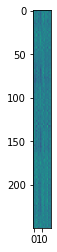

In [52]:
import matplotlib.pyplot as plt
tup = next(it)
img = tup[0][0].numpy()
plt.imshow(img)
print(tup[1].numpy())
img.min(), img.max()

## CNN

In [46]:
w_f1 = tfa.metrics.F1Score(len(d_seizures.keys()), average='weighted', name='w_f1')

In [47]:
tup[0].numpy().shape[1:]

(250, 20)

In [48]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [ ]:
exp_name = 'results.pkl'
exp_path = 'exp_results/'+nb_name.split('.')[0]+datetime.today().strftime('_%Y_%m_%d_%H_%M_%S')
os.makedirs(exp_path, exist_ok=True)
exp_path_results = os.path.join(exp_path, exp_name)
print(exp_path_results)

l_models = []

for i_split in range(1, 4):
    i_split = str(i_split)
    print(f'Processing split {i_split}')
    batch_size = 512
    num_classes = len(d_seizures.keys())
    epochs = 60

    # Get the actual batch
    train_val = list(set(cv[i_split]['train']).intersection(existing_files))
    train_val_labels = [path.split('_')[-1][:4] for path in train_val]

    train, val = train_test_split(train_val, test_size=.1, random_state=seed, 
                                shuffle=True, stratify=train_val_labels)
    rnd.shuffle(train)

    ds_train = get_tf_dataset(train, batch_size, read_train_data, True)
    ds_val = get_tf_dataset(val, batch_size, read_test_data, False)

    model = tf.keras.Sequential()
    model.add(SeparableConv1D(64, 8, dilation_rate=10, input_shape=tup[0].numpy().shape[1:]))
    model.add(Activation('relu'))
    model.add(SeparableConv1D(64, 8))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(AveragePooling1D(pool_size=2))

    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    if i_split=='1':
        model.summary()
#         break

    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

    # TensorBoard
    logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    early_stopping = tf.keras\
        .callbacks.EarlyStopping(monitor='val_w_f1', patience=10,
                                 restore_best_weights=False,
                                 verbose=1, mode='max',
                                 min_delta=0.03)
    
    model_path = os.path.join(exp_path, f'model_cv_{i_split}')
    model_checkpoint_callback = tf\
        .keras.callbacks\
        .ModelCheckpoint(filepath=model_path,
                        save_weights_only=False,
                        monitor='val_w_f1',
                        mode='max', verbose=1,
                        save_best_only=True)

    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy', w_f1])

    model.fit(ds_train.repeat(),
            epochs=epochs,
            steps_per_epoch=500,
            validation_data=ds_val,
            shuffle=False,
            callbacks=[tensorboard_callback, early_stopping, model_checkpoint_callback])
    
    l_models.append(model)

## Results

In [53]:
exp_path = 'exp_results/tuh_waveform_T_experiment_2_2021_03_31_23_28_14'
d_key_seizures = {v: k for k, v in d_seizures.items()}
n_classes = len(d_seizures.keys())

In [54]:
def get_prob_record_patient(series):
    arr = np.zeros(n_classes)
    series = series/series.sum()
    ind = series.index
    values = series.values
    arr[ind] = values
    return list(arr)

In [55]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

1373/1373 [==============================] - 14s 10ms/step
CV 1. f1_frame: 0.5185, f1_seizure_patient: 0.6203


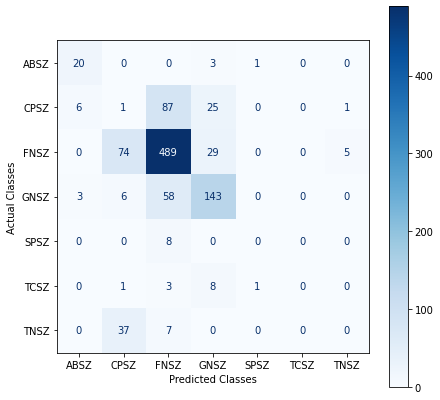

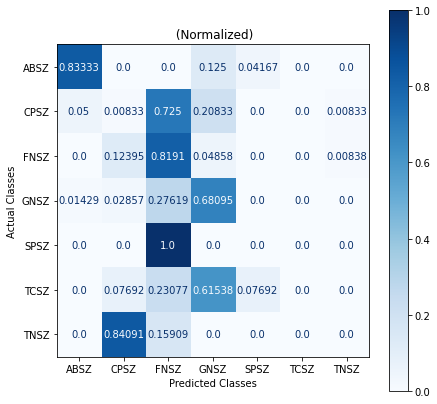

Average precision score, micro-averaged over all classes: 0.64


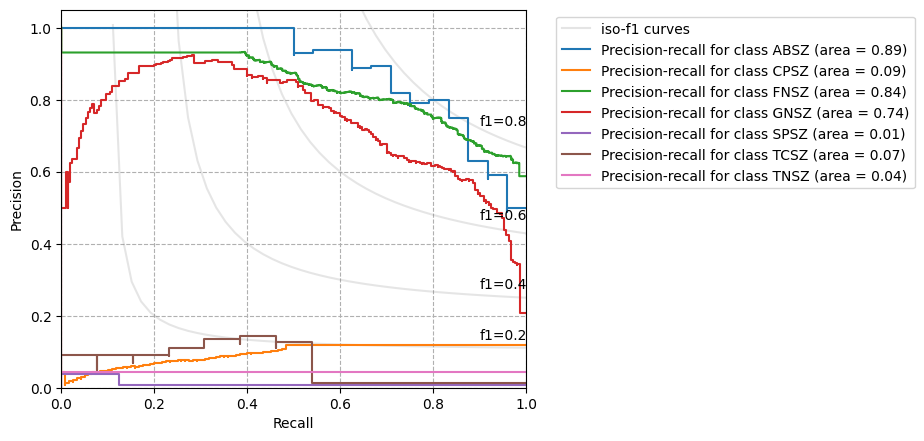

1732/1732 [==============================] - 17s 10ms/step
CV 2. f1_frame: 0.5702, f1_seizure_patient: 0.6502


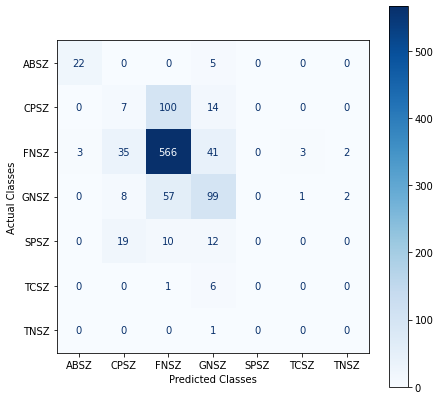

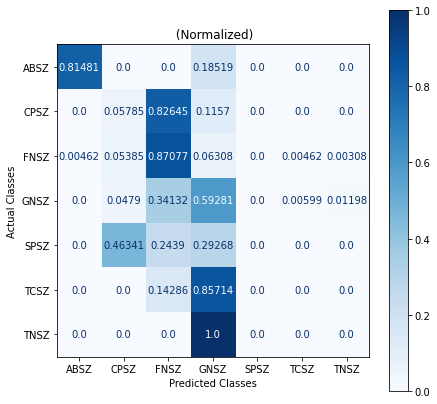

Average precision score, micro-averaged over all classes: 0.65


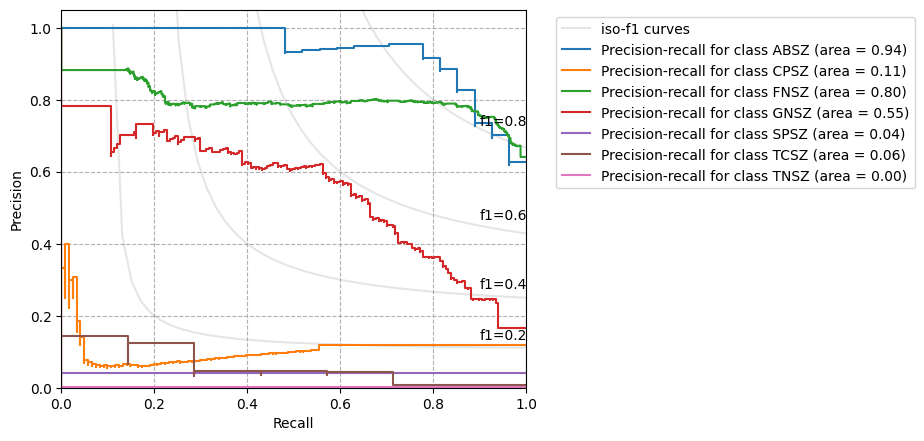

1597/1597 [==============================] - 15s 9ms/step
CV 3. f1_frame: 0.3721, f1_seizure_patient: 0.5616


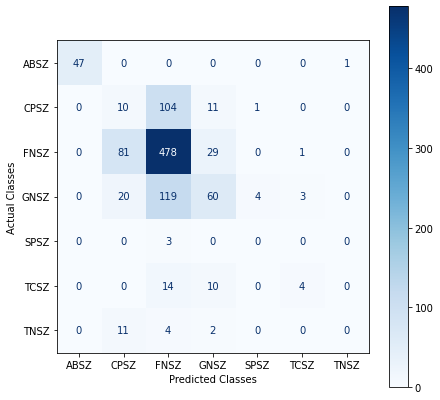

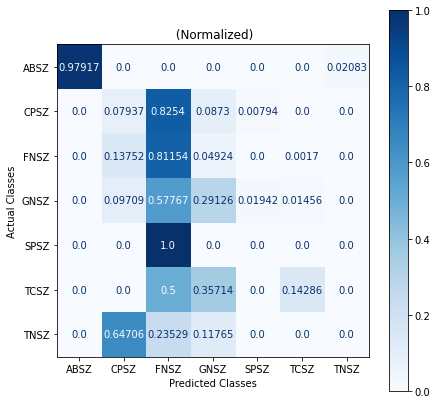

Average precision score, micro-averaged over all classes: 0.59


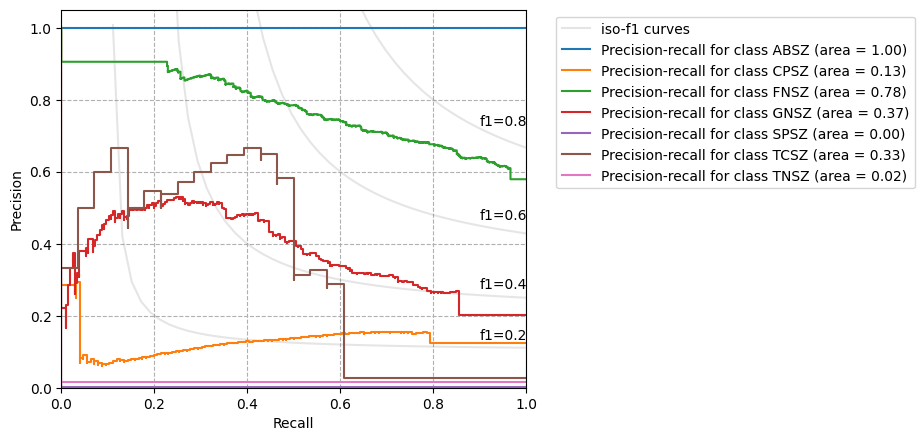

0.4869364013969142 0.08392279859135615
0.6106893922839717 0.03679968622485214
PRC
FNSZ    0.805469
GNSZ    0.553458
CPSZ    0.110259
ABSZ    0.943319
SPSZ    0.018360
TCSZ    0.152429
TNSZ    0.020336
dtype: float64
FNSZ    0.032278
GNSZ    0.183585
CPSZ    0.017412
ABSZ    0.053230
SPSZ    0.019610
TCSZ    0.154355
TNSZ    0.021391
dtype: float64


In [56]:
l_f1_seizure_patient = []
l_f1_frame = []
l_prc = []

for i in range(1, 4):
    arr_metrics = np.zeros(n_classes)
    # Read model
    i_split = str(i)
    path_model = os.path.join(exp_path, f'model_cv_{i_split}')

    model = keras.models.load_model(path_model)


    test = list(set(cv[i_split]['val']).intersection(existing_files))
    
    y_pred_prob = model.predict(get_tf_dataset(test, 64, read_test_data, False), verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=-1)
    ds_test = get_tf_dataset(test, 1, read_test_data, False)
    y_true = [np.where(e[1].numpy()[0] == 1)[0][0] for e in iter(ds_test)]

    # F1 per image
    f1_frame = f1_score(y_true, y_pred, average='weighted')

    # F1 per EEG
    y_size = [len(y) for _, y in read_test_data(test)]
    y_ = np.cumsum(y_size)
    slice_index = zip(np.insert(y_, 0, 0)[:-1], y_)
    l_results = [(y_true[l],
                  pd.Series(y_pred[l:r]).value_counts().index[0],
                  pd.Series(y_pred[l:r]).value_counts())
                 for l, r in slice_index]
    df_results = pd.DataFrame(l_results)

    f1_frame = f1_score(y_true, y_pred, average='weighted')
    f1_seizure_patient = f1_score(df_results[0], df_results[1], average='weighted')
    l_f1_frame.append(f1_frame)
    l_f1_seizure_patient.append(f1_seizure_patient)
    
    print(f'CV {i_split}. f1_frame: {round(f1_frame, 4)}, f1_seizure_patient: {round(f1_seizure_patient, 4)}')

    cm = ConfusionMatrix(actual_vector=df_results[0].values, 
                         predict_vector=df_results[1].values,
                         digit=2) # Create CM From Data
    cm.relabel(mapping=d_key_seizures)
    cm.plot(cmap=plt.cm.Blues,
            number_label=True,
            plot_lib="matplotlib",
            title='')

    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    # fig.savefig('test2png.png', dpi=100)

    cm.plot(cmap=plt.cm.Blues,number_label=True, normalized=True, plot_lib="matplotlib", title='')
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    plt.show()

    
    
    # From the count per class to normalize between 0-1 to get probability
    df_results['prob'] = df_results[2].map(get_prob_record_patient)
    Y_test = label_binarize(df_results[0].values, classes=range(n_classes))
    y_score = np.array(df_results['prob'].tolist())

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    fig, ax = plt.subplots(figsize=(6,6), dpi=100)

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
    lines.append(l)
    labels.append('iso-f1 curves')

    for i in [c for _, c in sorted(d_seizures.items())]:
        l, = plt.step(recall[i], precision[i], lw=1.5, where='post')
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(d_key_seizures[i], average_precision[i]))
        arr_metrics[i] = average_precision[i]
        

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.title('Extension of Precision-Recall curve to multi-class')
    ax.grid(linestyle='--')
    plt.legend(lines, labels, bbox_to_anchor=(1.05, 1))
    plt.show()
    l_prc.append(arr_metrics)
    

print(np.mean(l_f1_frame), np.std(l_f1_frame))
print(np.mean(l_f1_seizure_patient), np.std(l_f1_seizure_patient))

print('PRC')
df = pd.DataFrame(l_prc)
df.columns = df.columns.map(d_key_seizures)
print(df.mean())
print(df.std())

In [57]:
pd.DataFrame([df.mean(), df.std()]).T.sort_index().round(2)

,0,1
ABSZ,0.94,0.05
CPSZ,0.11,0.02
FNSZ,0.81,0.03
GNSZ,0.55,0.18
SPSZ,0.02,0.02
TCSZ,0.15,0.15
TNSZ,0.02,0.02


## Study by frames length

In [58]:
l_mean_std_f1 = []
l_df_prc = []
l_n_frames = [1]+list(range(5, 51, 5))+[-1]

for n_frames in l_n_frames:

    l_f1_seizure_patient = []
    l_f1_frame = []
    l_prc = []

    for i in range(1, 4):
        arr_metrics = np.zeros(n_classes)
        # Read model
        i_split = str(i)
        path_model = os.path.join(exp_path, f'model_cv_{i_split}')

        model = keras.models.load_model(path_model)


        test = list(set(cv[i_split]['val']).intersection(existing_files))
        y_pred_prob = model.predict(get_tf_dataset(test, 64, read_test_data_first_frames, 
                                                   False, first_frames=n_frames), 
                                    verbose=1)
        y_pred = np.argmax(y_pred_prob, axis=-1)
        ds_test = get_tf_dataset(test, 1, read_test_data_first_frames, False, first_frames=n_frames)
        y_true = [np.where(e[1].numpy()[0] == 1)[0][0] for e in iter(ds_test)]

        # F1 per image
        f1_frame = f1_score(y_true, y_pred, average='weighted')

        # F1 per EEG
        y_size = [len(y) for _, y in read_test_data_first_frames(test, first_frames=n_frames)]
        y_ = np.cumsum(y_size)
        slice_index = zip(np.insert(y_, 0, 0)[:-1], y_)
        l_results = [(y_true[l],
                      pd.Series(y_pred[l:r]).value_counts().index[0],
                      pd.Series(y_pred[l:r]).value_counts())
                     for l, r in slice_index]
        df_results = pd.DataFrame(l_results)

        f1_frame = f1_score(y_true, y_pred, average='weighted')
        f1_seizure_patient = f1_score(df_results[0], df_results[1], average='weighted')
        l_f1_frame.append(f1_frame)
        l_f1_seizure_patient.append(f1_seizure_patient)

        # print(f'CV {i_split}. f1_frame: {round(f1_frame, 4)}, f1_seizure_patient: {round(f1_seizure_patient, 4)}')
    # 
        # cm = ConfusionMatrix(actual_vector=df_results[0].values, 
        #                      predict_vector=df_results[1].values,
        #                      digit=2) # Create CM From Data
        # cm.relabel(mapping=d_key_seizures)
        # cm.plot(cmap=plt.cm.Blues,
        #         number_label=True,
        #         plot_lib="matplotlib",
        #         title='')
    # 
        # fig = plt.gcf()
        # fig.set_size_inches(7, 7)
        # # fig.savefig('test2png.png', dpi=100)
    # 
        # cm.plot(cmap=plt.cm.Blues,number_label=True, normalized=True, plot_lib="matplotlib", title='')
        # fig = plt.gcf()
        # fig.set_size_inches(7, 7)
        # plt.show()



        # From the count per class to normalize between 0-1 to get probability
        df_results['prob'] = df_results[2].map(get_prob_record_patient)
        Y_test = label_binarize(df_results[0].values, classes=range(n_classes))
        y_score = np.array(df_results['prob'].tolist())

        # For each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
            y_score.ravel())
        average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                             average="micro")
        # print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        #       .format(average_precision["micro"]))

        # fig, ax = plt.subplots(figsize=(6,6), dpi=100)
    # 
        # f_scores = np.linspace(0.2, 0.8, num=4)
        # lines = []
        # labels = []
        # for f_score in f_scores:
        #     x = np.linspace(0.01, 1)
        #     y = f_score * x / (2 * x - f_score)
        #     l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        #     plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        # 
        # lines.append(l)
        # labels.append('iso-f1 curves')
        # l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
        # lines.append(l)
        # labels.append('micro-average Precision-recall (area = {0:0.2f})'
        #               ''.format(average_precision["micro"]))

        for i in [c for _, c in sorted(d_seizures.items())]:
            # l, = plt.step(recall[i], precision[i], lw=1.5, where='post')
            # lines.append(l)
            # labels.append('Precision-recall for class {0} (area = {1:0.2f})'
            #               ''.format(d_key_seizures[i], average_precision[i]))
            arr_metrics[i] = average_precision[i]


        # fig = plt.gcf()
        # fig.subplots_adjust(bottom=0.25)
        # plt.xlim([0.0, 1.0])
        # plt.ylim([0.0, 1.05])
        # plt.xlabel('Recall')
        # plt.ylabel('Precision')
        # # plt.title('Extension of Precision-Recall curve to multi-class')
        # ax.grid(linestyle='--')
        # plt.legend(lines, labels, bbox_to_anchor=(1.05, 1))
        # plt.show()
        l_prc.append(arr_metrics)

    print(f'Getting first {n_frames} frames')
    l_mean_std_f1.append((np.mean(l_f1_seizure_patient), np.std(l_f1_seizure_patient)))
    print(np.mean(l_f1_seizure_patient), np.std(l_f1_seizure_patient))
    
    # PRC
    df = pd.DataFrame(l_prc)
    df.columns = df.columns.map(d_key_seizures)
    l_df_prc.append(df)

16/16 [==============================] - 3s 210ms/step
Getting first 1 frames
0.5426683262321409 0.03641598498034334
79/79 [==============================] - 4s 48ms/step
Getting first 5 frames
0.5751568841689967 0.038621427374548094
156/156 [==============================] - 4s 27ms/step
Getting first 10 frames
0.5894121397472499 0.04020573416904003
229/229 [==============================] - 5s 21ms/step
Getting first 15 frames
0.593801141614505 0.04360646244435551
298/298 [==============================] - 5s 17ms/step
Getting first 20 frames
0.5962078806108525 0.04452492523516953
362/362 [==============================] - 6s 16ms/step
Getting first 25 frames
0.5990514436846816 0.04239387050959591
421/421 [==============================] - 6s 14ms/step
Getting first 30 frames
0.5998061454141795 0.04239666776494734
476/476 [==============================] - 7s 14ms/step
Getting first 35 frames
0.5978833188262532 0.040313978861143296
526/526 [==============================] - 7s 13ms/s

In [64]:
l_frames = []
for path in train_val+test:
    with open(os.path.join(path_dataset, path), 'rb') as f:
        data = pickle.load(f)
    l_frames.append(data.data.shape[0])
pd.Series(l_frames).describe().round(2)

count    3048.00
mean      103.38
std       242.95
min         1.00
25%        24.00
50%        52.00
75%       100.00
max      3272.00
dtype: float64

In [59]:
l_df_prc[1].mean()

FNSZ    0.722851
GNSZ    0.420860
CPSZ    0.122122
ABSZ    0.882817
SPSZ    0.017086
TCSZ    0.055497
TNSZ    0.020336
dtype: float64

In [60]:
l_analized_frames = []

for i in range(1, 4):
    i_split = str(i)
    test = list(set(cv[i_split]['val']).intersection(existing_files))
    analized_frames = [sum(len(e[0]) for e in read_test_data_first_frames(test, n_frames)) 
                       for n_frames in l_n_frames]
    l_analized_frames.append(analized_frames)

In [61]:
l = pd.Series([str(f) for f in l_n_frames]).str.replace('-1', 'All')

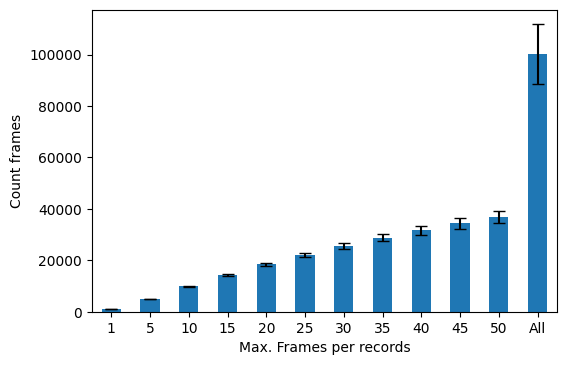

In [68]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
df = pd.DataFrame(l_analized_frames, columns=l)
df.mean().plot.bar(yerr=df.std(), capsize=4, rot=0, ax=ax)
ax.set_xlabel('Max. Frames per records')
ax.set_ylabel('Count frames')
fig.savefig(f"pdf/max_frames_count_frames.pdf", bbox_inches='tight')

In [82]:
df.mean().round()

1        1016.0
5        5041.0
10       9830.0
15      14296.0
20      18463.0
25      22231.0
30      25639.0
35      28782.0
40      31672.0
45      34327.0
50      36805.0
All    100270.0
dtype: float64

In [83]:
100270/36805

2.7243581035185436

In [81]:
(df.mean()/df.mean()['All']).mul(100).round(2)

1        1.01
5        5.03
10       9.80
15      14.26
20      18.41
25      22.17
30      25.57
35      28.70
40      31.59
45      34.23
50      36.71
All    100.00
dtype: float64

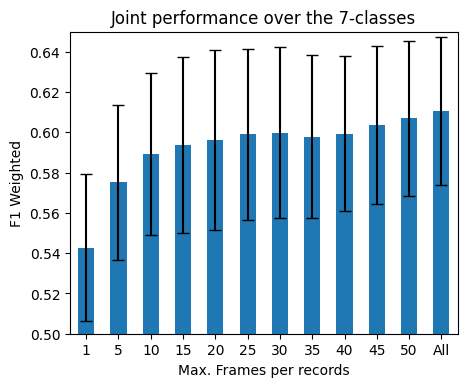

In [65]:
df = pd.DataFrame(l_mean_std_f1, index=l)
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
df[0].plot.bar(yerr=df[1], capsize=4, rot=0, ax=ax, ylim=(0.5,.65))
ax.set_xlabel('Max. Frames per records')
ax.set_ylabel('F1 Weighted')
ax.set_title('Joint performance over the 7-classes')
fig.savefig(f"pdf/max_frames_f1.pdf", bbox_inches='tight')

In [67]:
df.round(3)

,0,1
1,0.543,0.036
5,0.575,0.039
10,0.589,0.040
15,0.594,0.044
20,0.596,0.045
25,0.599,0.042
30,0.600,0.042
35,0.598,0.040
40,0.599,0.039
45,0.604,0.039


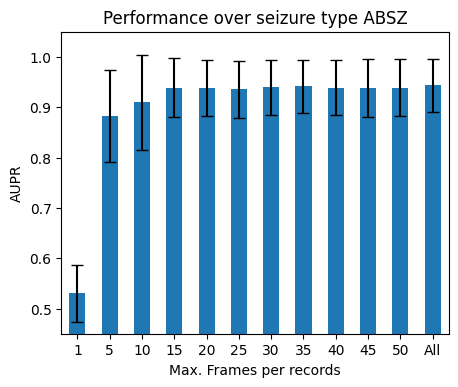

In [84]:
l_prc = []
sz = 'ABSZ'
for i in range(len(l_df_prc)):
    l_prc.append((l_df_prc[i].mean()[sz], l_df_prc[i].std()[sz]))

fig, ax = plt.subplots(figsize=(5,4), dpi=100)
df = pd.DataFrame(l_prc, index=l)
df[0].plot.bar(yerr=df[1], capsize=4, ylim=(0.45,1.05), rot=0)
ax.set_xlabel('Max. Frames per records')
ax.set_ylabel('AUPR')
ax.set_title(f'Performance over seizure type {sz}')
fig.savefig(f"pdf/aupr_{sz}.pdf", bbox_inches='tight')

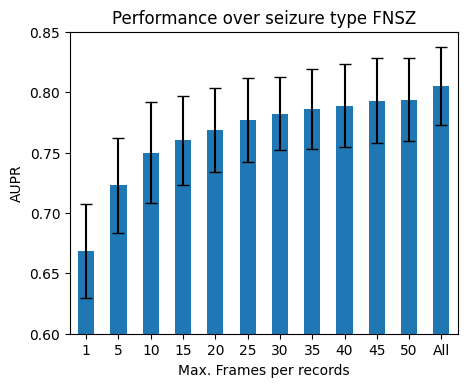

In [85]:
l_prc = []
sz = 'FNSZ'
for i in range(len(l_df_prc)):
    l_prc.append((l_df_prc[i].mean()[sz], l_df_prc[i].std()[sz]))

fig, ax = plt.subplots(figsize=(5,4), dpi=100)
df = pd.DataFrame(l_prc, index=l)
df[0].plot.bar(yerr=df[1], capsize=4, ylim=(0.6,.85), rot=0)
ax.set_xlabel('Max. Frames per records')
ax.set_ylabel('AUPR')
ax.set_title(f'Performance over seizure type {sz}')
fig.savefig(f"pdf/aupr_{sz}.pdf", bbox_inches='tight')

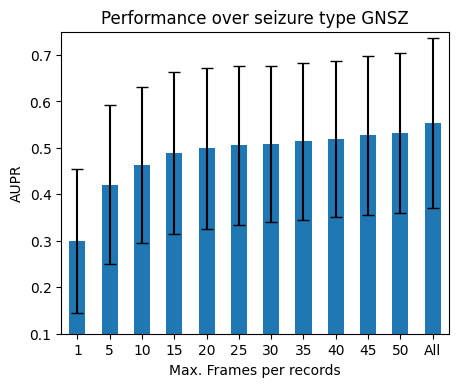

In [86]:
l_prc = []
sz = 'GNSZ'
for i in range(len(l_df_prc)):
    l_prc.append((l_df_prc[i].mean()[sz], l_df_prc[i].std()[sz]))

fig, ax = plt.subplots(figsize=(5,4), dpi=100)
df = pd.DataFrame(l_prc, index=l)
df[0].plot.bar(yerr=df[1], capsize=4, ylim=(0.1,.75), rot=0)
ax.set_xlabel('Max. Frames per records')
ax.set_ylabel('AUPR')
ax.set_title(f'Performance over seizure type {sz}')
fig.savefig(f"pdf/aupr_{sz}.pdf", bbox_inches='tight')

#### Seconds by frame count

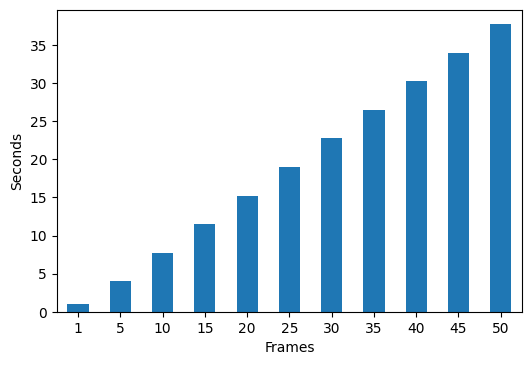

In [37]:
length_frame = 1
overlapping = .25

l = l_n_frames[:-1]
seconds = [(f*length_frame)-((f-1)*overlapping) for f in l]

fig, ax = plt.subplots(figsize=(6,4), dpi=100)
df = pd.DataFrame((l, seconds)).T
df.columns = ['Frames', 'Seconds']
df.assign(Frames=lambda df: df['Frames'].astype(int)).set_index('Frames').plot.bar(rot=0, ax=ax)
ax.set_ylabel('Seconds')
ax.get_legend().remove()
fig.savefig(f"pdf/frames_seconds.pdf", bbox_inches='tight')